In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
abdallahwagih_retina_blood_vessel_path = kagglehub.dataset_download('abdallahwagih/retina-blood-vessel')

print('Data source import complete.')


Data source import complete.


Segue um resumo das principais modificações sugeridas para o seu notebook, com as respectivas justificativas:

---

### 1. **Uso Correto de Dados de Validação**
**Modificação:**  
Utilizar `validation_data=(X_test, y_test)` no método `fit` ao invés de `validation_split`, garantindo que o conjunto de validação seja sempre o mesmo e realmente nunca visto pelo modelo.

**Justificativa:**  
Isso permite monitorar o desempenho do modelo em dados não vistos durante o treinamento, reduzindo o risco de overfitting e facilitando a comparação entre diferentes execuções.

---

### 2. **Aumento do Batch Size**
**Modificação:**  
Aumentar o `batch_size` para 16 ou 32.

**Justificativa:**  
Batchs pequenos tornam o treinamento mais lento e instável. Um batch maior proporciona atualizações de pesos mais estáveis e acelera o treinamento.

---

### 3. **Inclusão de Callbacks**
**Modificação:**  
Adicionar callbacks como `EarlyStopping` e `ModelCheckpoint` ao treinamento.

**Justificativa:**  
Permite interromper o treinamento automaticamente quando não há mais melhora na validação, evitando overfitting e economizando tempo computacional. O `ModelCheckpoint` garante que o melhor modelo seja salvo.

---

### 4. **Batch Normalization e Dropout**
**Modificação:**  
Adicionar camadas de `BatchNormalization` após convoluções e `Dropout` após pooling e blocos do decoder na U-Net.

**Justificativa:**  
`BatchNormalization` estabiliza e acelera o treinamento. `Dropout` reduz o risco de overfitting, especialmente em modelos complexos ou com poucos dados.

---

### 5. **Aumentação de Dados (opcional)**
**Modificação:**  
Se desejar, usar `ImageDataGenerator` para aumentar imagens e máscaras de forma sincronizada.

**Justificativa:**  
Aumenta a diversidade dos dados de treino, melhorando a generalização do modelo.

---

Essas modificações tornam o treinamento mais robusto, estável e confiável, além de facilitar o acompanhamento do desempenho real do modelo.

In [2]:
%pip install numpy --upgrade
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


2025-04-18 21:44:55.103432: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-18 21:44:55.333327: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-18 21:44:55.476807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745012695.780563    9373 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745012695.871574    9373 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745012696.000232    9373 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
image_dir = '/kaggle/input/retina-blood-vessel/Data/train/image'
mask_dir = '/kaggle/input/retina-blood-vessel/Data/train/mask'

In [4]:
def load_data(image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            image = load_img(os.path.join(image_dir, filename), target_size=img_size)
            image = img_to_array(image) / 255.0
            images.append(image)

            mask = load_img(os.path.join(mask_dir, filename), target_size=img_size, color_mode='grayscale')
            mask = img_to_array(mask) / 255.0
            masks.append(mask)

    return np.array(images), np.array(masks)

In [5]:
 

image_dir = os.path.join(abdallahwagih_retina_blood_vessel_path, 'Data/train/image')
mask_dir = os.path.join(abdallahwagih_retina_blood_vessel_path, 'Data/train/mask')
images, masks = load_data(image_dir, mask_dir) #Carrega

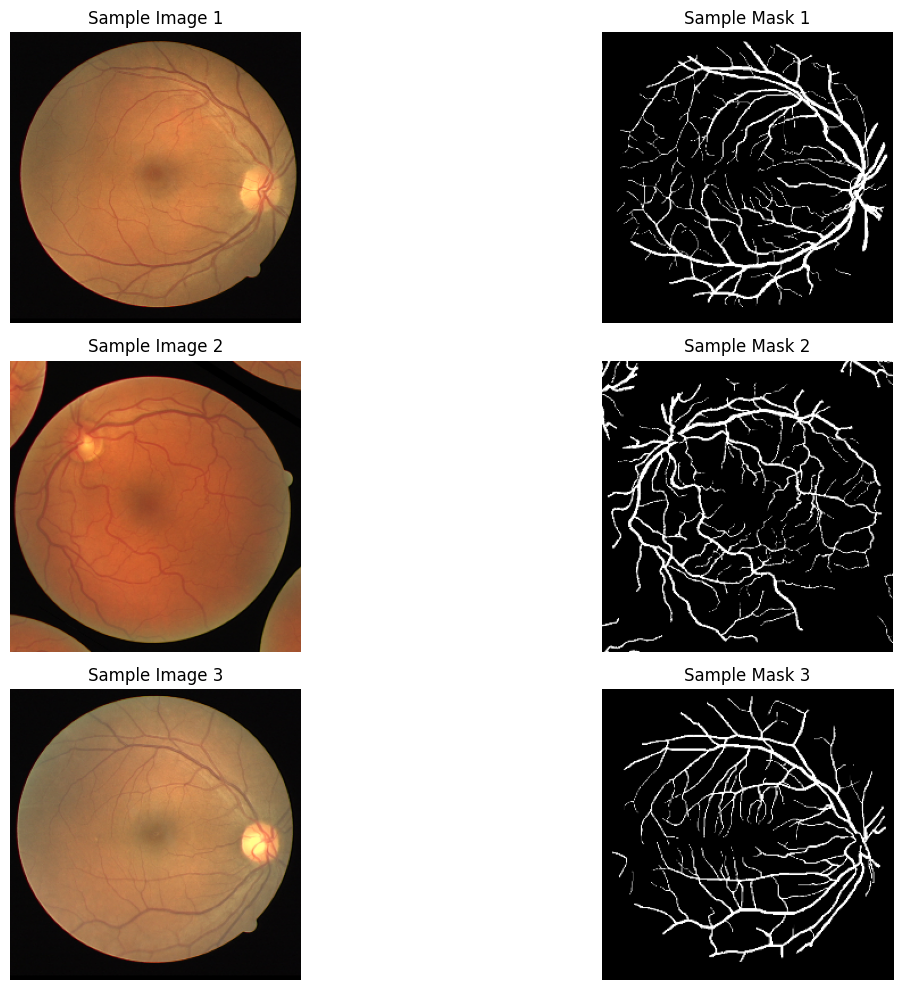

In [6]:
plt.figure(figsize=(15, 10))

sample_images = images[:3]
sample_masks = masks[:3]

for i in range(3):
    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Sample Image {i+1}")
    plt.axis('off')

    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(sample_masks[i].squeeze(), cmap='gray')
    plt.title(f"Sample Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)


: 

In [ ]:
# Importa o módulo 'layers' do Keras, que contém as peças fundamentais para construir as camadas da rede neural (Convolução, Pooling, Input, etc.).
from tensorflow.keras import layers

# Importa a classe 'Model' do Keras, que é usada para agrupar as camadas definidas em um objeto de modelo completo, com entradas e saídas.
from tensorflow.keras.models import Model

# Define uma função chamada 'unet_model'. Funções são blocos de código reutilizáveis. Esta função construirá e retornará o modelo U-Net.
# 'input_size' é um parâmetro da função com um valor padrão de (256, 256, 3). Isso significa que, se você não especificar um tamanho ao chamar a função,
# ela assumirá que a imagem de entrada tem 256 pixels de altura, 256 de largura e 3 canais de cor (RGB).
def unet_model(input_size=(256, 256, 3)):

    # Cria a camada de entrada do modelo. 'layers.Input' define o formato (shape) dos dados que o modelo espera receber.
    # O formato é especificado pelo parâmetro 'input_size'. A variável 'inputs' agora guarda uma representação simbólica dessa entrada.
    inputs = layers.Input(input_size)

    # --- CAMINHO DE CONTRAÇÃO (ENCODER) ---
    # Este é o lado esquerdo do "U", onde extraímos características e reduzimos a dimensão espacial.

    # Bloco Convolucional 1:
    # 'layers.Conv2D' cria uma camada de convolução 2D.
    # 64: O número de filtros (ou kernels) na camada. Cada filtro aprende a detectar um padrão diferente.
    # (3, 3): O tamanho do kernel (janela) de convolução (3 pixels de altura por 3 de largura).
    # activation='relu': A função de ativação 'Rectified Linear Unit' (ReLU) a ser aplicada após a convolução. Introduz não-linearidade.
    # padding='same': Garante que a saída da convolução tenha as mesmas dimensões espaciais (altura e largura) que a entrada, preenchendo as bordas se necessário.
    # (inputs): Especifica que a entrada para esta camada é a camada 'inputs' definida anteriormente.
    # A saída é armazenada na variável 'conv1'.
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    # Aplica uma segunda camada convolucional idêntica à anterior. A entrada agora é a saída da primeira convolução ('conv1').
    # Usar duas convoluções seguidas permite que a rede aprenda características mais complexas antes do pooling.
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    # 'layers.MaxPooling2D' cria uma camada de max pooling.
    # (2, 2): O tamanho da janela de pooling. Ela pega o valor máximo em cada janela 2x2 da entrada.
    # Isso reduz a altura e a largura da representação pela metade (downsampling), tornando o modelo mais robusto a pequenas variações e reduzindo a computação.
    # A entrada é 'conv1', e a saída é 'pool1'. O resultado de 'conv1' (antes do pooling) será usado depois na skip connection.
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Bloco Convolucional 2:
    # Similar ao Bloco 1, mas agora com 128 filtros, operando sobre a saída do pooling anterior ('pool1').
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    # Novo pooling, reduzindo novamente a dimensão espacial pela metade. A saída é 'pool2'. 'conv2' é guardado para a skip connection.
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bloco Convolucional 3:
    # Similar aos anteriores, agora com 256 filtros, operando sobre 'pool2'.
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    # Terceiro pooling. A saída é 'pool3'. 'conv3' é guardado para a skip connection.
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Bloco Convolucional 4 (Bottleneck - Gargalo):
    # A parte mais profunda do "U". Geralmente tem o maior número de filtros (aqui, 512).
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    # Note que não há pooling após este bloco. Esta é a representação com a menor resolução espacial e maior profundidade de características.

    # --- CAMINHO DE EXPANSÃO (DECODER) ---
    # Este é o lado direito do "U", onde aumentamos a resolução espacial e combinamos com características do encoder para localização precisa.

    # Bloco de Expansão 1:
    # 'layers.UpSampling2D' aumenta a resolução espacial (altura e largura) da entrada.
    # (2, 2): Fator de aumento. Dobra a altura e a largura da saída de 'conv4'.
    # O resultado ('up1') tem agora as mesmas dimensões espaciais que 'conv3'.
    up1 = layers.UpSampling2D((2, 2))(conv4)
    # 'layers.concatenate' junta (concatena) duas ou mais camadas ao longo de um eixo especificado.
    # [up1, conv3]: A lista das camadas a serem concatenadas: a saída do upsampling ('up1') e a saída guardada do Bloco 3 do encoder ('conv3').
    # axis=3: O eixo ao longo do qual concatenar. Para imagens no formato (batch, altura, largura, canais), o eixo 3 é o dos canais/filtros.
    # Esta é a "skip connection", crucial na U-Net para combinar informações de baixo nível (detalhes de 'conv3') com informações de alto nível ('up1').
    concat1 = layers.concatenate([up1, conv3], axis=3)
    # Aplica convoluções sobre as características concatenadas ('concat1'), agora com 256 filtros.
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    # Bloco de Expansão 2:
    # Repete o processo: upsampling da saída anterior ('conv5').
    up2 = layers.UpSampling2D((2, 2))(conv5)
    # Concatena ('skip connection') com a saída guardada do Bloco 2 do encoder ('conv2').
    concat2 = layers.concatenate([up2, conv2], axis=3)
    # Aplica convoluções sobre as características concatenadas, agora com 128 filtros.
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    # Bloco de Expansão 3:
    # Último upsampling, retornando à resolução espacial original (igual à da entrada).
    up3 = layers.UpSampling2D((2, 2))(conv6)
    # Concatena ('skip connection') com a saída guardada do Bloco 1 do encoder ('conv1').
    concat3 = layers.concatenate([up3, conv1], axis=3)
    # Aplica as últimas convoluções do decoder, agora com 64 filtros.
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # --- CAMADA DE SAÍDA ---

    # Camada convolucional final com kernel 1x1.
    # 1: Número de filtros. Como queremos uma segmentação binária (objeto vs. fundo), usamos 1 filtro para gerar um mapa de probabilidade.
    # (1, 1): Tamanho do kernel. Uma convolução 1x1 processa cada pixel individualmente, mapeando os 64 canais de 'conv7' para 1 canal de saída.
    # activation='sigmoid': Função de ativação Sigmoid. Ela comprime a saída de cada pixel para um valor entre 0 e 1.
    # Isso é interpretado como a probabilidade do pixel pertencer à classe positiva (geralmente, o objeto de interesse).
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    # Cria o objeto do modelo Keras final.
    # inputs: Define qual(is) camada(s) são as entradas do modelo (a camada 'inputs' que definimos no início).
    # outputs: Define qual(is) camada(s) são as saídas do modelo (a camada 'outputs' que acabamos de definir).
    # O Keras automaticamente conecta todas as camadas entre 'inputs' e 'outputs' para formar o grafo computacional do modelo.
    model = Model(inputs, outputs)

    # A função retorna o objeto 'model' construído.
    return model

# --- Fora da função ---

# Chama a função 'unet_model' para criar uma instância do modelo U-Net.
# Usa o tamanho de entrada padrão (256, 256, 3). O modelo construído é armazenado na variável 'model'.
model = unet_model(input_size=(256, 256, 3))

# Compila o modelo. Este passo configura o processo de treinamento.
# optimizer='adam': Especifica o algoritmo de otimização 'Adam', que é responsável por atualizar os pesos da rede durante o treinamento para minimizar a perda. Adam é uma escolha popular e eficiente.
# loss='binary_crossentropy': Define a função de perda (loss function). 'binary_crossentropy' é adequada para problemas de classificação binária (ou segmentação binária pixel a pixel, como aqui). Ela mede a diferença entre as probabilidades previstas pelo modelo (saída da Sigmoid) e os valores reais (0 ou 1) nas máscaras de treinamento.
# metrics=['accuracy']: Especifica as métricas a serem calculadas e exibidas durante o treinamento e avaliação. 'accuracy' calcula a proporção de pixels classificados corretamente. (Embora comum, métricas como Dice ou IoU são muitas vezes mais informativas para segmentação).
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Imprime um resumo textual da arquitetura do modelo no console.
# Mostra cada camada, seu formato de saída (output shape) e o número de parâmetros treináveis. Útil para verificar a estrutura.
model.summary()

# Inicia o processo de treinamento do modelo.
# images: Os dados de entrada (as imagens a serem segmentadas). Deve ser um array NumPy ou tensor TensorFlow.
# masks: Os dados de saída desejados (as máscaras de segmentação verdadeiras, correspondentes às 'images'). Devem ter o mesmo formato espacial que a saída do modelo e valores 0 ou 1.
# epochs=5: O número de vezes que o algoritmo de treinamento passará por todo o conjunto de dados ('images' e 'masks').
# batch_size=32: O número de amostras (imagens e máscaras) a serem processadas em cada atualização dos pesos do modelo. O dataset é dividido em lotes (batches) de tamanho 32.
# validation_split=0.2: Reserva 20% dos dados fornecidos ('images' e 'masks') para validação. Esses dados não são usados para treinar os pesos, mas sim para avaliar o desempenho do modelo em dados "não vistos" ao final de cada época. Isso ajuda a monitorar o overfitting.
# A função 'fit' retorna um objeto 'history' que contém informações sobre o treinamento (valores de perda e métricas em cada época, tanto para treino quanto para validação).
history = model.fit(images, masks, epochs=5, batch_size=32, validation_split=0.2)


2025-04-18 21:45:02.395810: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


2025-04-18 21:45:02.634352: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50331648 exceeds 10% of free system memory.
2025-04-18 21:45:06.422726: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.
2025-04-18 21:45:06.899969: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.
2025-04-18 21:45:08.958299: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-04-18 21:45:09.063322: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

image = images[0]
true_mask = masks[0]

predicted_mask = model.predict(np.expand_dims(image, axis=0))
predicted_mask = np.squeeze(predicted_mask)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models
import segmentation_models as sm

BACKBONE = 'efficientnetb0'

model = sm.Unet(BACKBONE, input_shape=(256, 256, 3), encoder_weights='imagenet')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(images, masks, epochs=10, batch_size=32, validation_split=0.2)




In [ ]:
image = images[0]
predicted_mask = model.predict(np.expand_dims(image, axis=0))
predicted_mask = np.squeeze(predicted_mask)

import matplotlib.pyplot as plt

true_mask = masks[0]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [ ]:

BACKBONE = 'efficientnetb0'

model = sm.FPN(BACKBONE, input_shape=(256, 256, 3), encoder_weights='imagenet', classes=1, activation='sigmoid')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

history = model.evaluate(X_test, y_test, batch_size=32)


In [ ]:
image = X_test[0]

predicted_mask = model.predict(np.expand_dims(image, axis=0))
predicted_mask = np.squeeze(predicted_mask)

true_mask = y_test[0]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [ ]:
import segmentation_models as sm

BACKBONE = 'efficientnetb0'

model = sm.Linknet(BACKBONE, input_shape=(256, 256, 3), encoder_weights='imagenet', classes=1, activation='sigmoid')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

history = model.evaluate(X_test, y_test, batch_size=32)


In [ ]:
image = X_test[0]

predicted_mask = model.predict(np.expand_dims(image, axis=0))
predicted_mask = np.squeeze(predicted_mask)

true_mask = y_test[0]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()